In [2]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from mathutils import geometry as pygeo
from mathutils import Vector
import json

################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (7,7)
frameSize = (1920,1080)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

imagesLeft = sorted(glob.glob('images/stereoLeft/*.png'))
imagesRight = sorted(glob.glob('images/stereoRight/*.png'))

for imgLeft, imgRight in zip(imagesLeft, imagesRight):

    imgL = cv.imread(imgLeft)
    imgR = cv.imread(imgRight)
    grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    grayR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv.findChessboardCorners(grayL, chessboardSize, None)
    retR, cornersR = cv.findChessboardCorners(grayR, chessboardSize, None)

    # If found, add object points, image points (after refining them)
    if retL and retR == True:

        objpoints.append(objp)

        cornersL = cv.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), criteria)
        imgpointsL.append(cornersL)

        cornersR = cv.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), criteria)
        imgpointsR.append(cornersR)


############## CALIBRATION #######################################################

retL, cameraMatrixL, distL, rvecsL, tvecsL = cv.calibrateCamera(objpoints, imgpointsL, frameSize, None, None)
heightL, widthL, channelsL = imgL.shape
newCameraMatrixL, roi_L = cv.getOptimalNewCameraMatrix(cameraMatrixL, distL, (widthL, heightL), 1, (widthL, heightL))

retR, cameraMatrixR, distR, rvecsR, tvecsR = cv.calibrateCamera(objpoints, imgpointsR, frameSize, None, None)
heightR, widthR, channelsR = imgR.shape
newCameraMatrixR, roi_R = cv.getOptimalNewCameraMatrix(cameraMatrixR, distR, (widthR, heightR), 1, (widthR, heightR))


########## Stereo Vision Calibration #############################################

flags = 0
flags |= cv.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo= (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, rot, trans, essentialMatrix, fundamentalMatrix = cv.stereoCalibrate(objpoints, imgpointsL, imgpointsR, newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], criteria_stereo, flags)

#rotation matrix => convert vector to matrix
rmatLeft = cv.Rodrigues(rvecsL[2])[0]
rmatRight = cv.Rodrigues(rvecsR[2])[0]

#full [R|t] matrix => add t in R
rotMatRight = np.concatenate((rmatRight,tvecsR[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft,tvecsL[0]), axis=1)

#camera matrix (A [R|t])
camLeft = cameraMatrixL @ rotMatLeft
camRight = cameraMatrixR @ rotMatRight

# find cx and cy for both cameras
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
#print('\n np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0) \n',np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0))
#print('\n np.transpose([[0,0,0,1]] : \n',np.transpose([[0,0,0,1]]))
print('\n centre optique gauche : \n',camWorldCenterLeft)

print(fundamentalMatrix)

'''Get all red pixels from the image'''
def getRed(fname):
    img = cv.imread(fname)
    #acces only R channel from BGR 
    red = img[:,:,2]
    #keep only pixels between 127 and 255 in the red channel
    ret, mask = cv.threshold(red,127,255,cv.THRESH_TOZERO)
    return mask


def getRedAvg(fname):
    red = getRed(fname)
    redPoints = [[],[],[]]

    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            #same as in find epilines
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints

'''Find epilines on right image of all given red points of left image'''
def getEpiLine(F,points):
    return F @ points

'''returns epilines (on right camera image) for all red points of the red line (of the left camera), from all images'''
def findEpilines(path):
    epilines = []
    scanLeft = sorted(glob.glob(path + '/*.png'))
    for img in scanLeft:           
        #get the red mask    
        red = getRed(img)
        tempEpilines = []
        pointsLeft = [[],[],[]]
        
        #i is the number of the line
        for i, line in enumerate(red):
            for pixel in line:
                if pixel != 0:
                    pixel = 1
            try:
                #weighted average => (0*0 + 1*0 + 2*0 + ... + 1248 * 1 + 1249 * 0) / n° of red pixels
                #for instance => (1261+1262+1267)/3 = 1263.33
                #give position of the red line in x axis
                pointsLeft[0].append(np.average(range(1920), weights = line))
                pointsLeft[1].append(i) # y axis
                pointsLeft[2].append(1)
            except:
                pass
        #from red line on left image, find corresponding epiline on right image
        #from red line on left image, find corresponding epiline on right image
        #try to use c2.computeCorrespondEpilines
        epilinesRight = getEpiLine(fundamentalMatrix, pointsLeft)
        tempEpilines.append(pointsLeft)        
        tempEpilines.append(epilinesRight)
        epilines.append(tempEpilines)
    return epilines

# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
epl = findEpilines('scanLeft/')
print(len(epl))

'''equation of a ligne => returns a value for y for a given x and coefficients'''
def lineY(coefs,x):
    a,b,c = coefs
    return-(c+a*x)/b

'''Find red points that are on an epiline, for each picture'''
def eplRedPoints(path,EplRight):
    points = []
    scanRight = sorted(glob.glob(path + '/*.png'))
    for l, img in enumerate(scanRight):            
        redPoints = getRedAvg(img)
        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1] #keep only epiline and not red points (EplRight[l][0])
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i]) #average position
                y = int(lineY(eplImg[:,i],x)) #use of y = (-ax+c)/b to find y position
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
            except:
                pass
        points.append(pointsRight)
    return points

pointsRight = eplRedPoints('scanRight/',epl)
print(len(pointsRight))
def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))


def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # get world/object 3D coordinates of all points 
    
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # characteristics points of retro projected lines
    
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # display retro projected lines
    
    
    # intersection between two retroprojected lines = real world point
    # Essayer d'utiliser cv.triangulatePoints()
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)

def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                #print(intersection)
                for inter in intersection:
                    inter *= 1000
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)

point = getObjectPoint()



 centre optique gauche : 
 [[ -0.46929287]
 [  4.08537028]
 [-21.9883103 ]
 [  1.        ]]
[[-1.19975321e-08 -1.20581369e-06  8.10150350e-04]
 [ 3.04336039e-06  5.88843356e-08 -1.39219298e-02]
 [-1.89773637e-03  1.22243249e-02  1.00000000e+00]]
26
26
(Vector((0.3553474545478821, 0.020302295684814453, 0.2006378173828125)), Vector((0.3561123311519623, 0.0308612659573555, 0.20254382491111755)))
(Vector((0.355610728263855, 0.020627975463867188, 0.20137977600097656)), Vector((0.3563770353794098, 0.031206445768475533, 0.20328907668590546)))
(Vector((0.3557164669036865, 0.021137237548828125, 0.20119476318359375)), Vector((0.35648271441459656, 0.03171484172344208, 0.2031036764383316)))
(Vector((0.35616421699523926, 0.021532058715820312, 0.20143699645996094)), Vector((0.3569324314594269, 0.03213655203580856, 0.20335052907466888)))
(Vector((0.3562464118003845, 0.02203083038330078, 0.20132064819335938)), Vector((0.3570145070552826, 0.032633572816848755, 0.20323362946510315)))
(Vector((0.3564959

(Vector((0.2763991355895996, 0.0529632568359375, -0.0951995849609375)), Vector((0.2763743996620178, 0.05261556804180145, -0.09526278078556061)))
(Vector((0.2762940526008606, 0.05338573455810547, -0.094818115234375)), Vector((0.2762688100337982, 0.05303112417459488, -0.09488256275653839)))
(Vector((0.2763051986694336, 0.053852081298828125, -0.09474372863769531)), Vector((0.2762797474861145, 0.05349423736333847, -0.09480875730514526)))
(Vector((0.2762036919593811, 0.054276466369628906, -0.09437179565429688)), Vector((0.27617770433425903, 0.053911350667476654, -0.09443813562393188)))
(Vector((0.27622276544570923, 0.054746150970458984, -0.09432411193847656)), Vector((0.2761966288089752, 0.05437871068716049, -0.094390869140625)))
(Vector((0.27624303102493286, 0.05521535873413086, -0.09427261352539062)), Vector((0.2762167155742645, 0.054845601320266724, -0.0943397805094719)))
(Vector((0.2762606739997864, 0.0556950569152832, -0.09428024291992188)), Vector((0.276266872882843, 0.055782038718461

(Vector((0.2271851897239685, 0.2454369068145752, -0.1788349151611328)), Vector((0.22755610942840576, 0.25059258937835693, -0.1779390126466751)))
(Vector((0.22723418474197388, 0.2459125518798828, -0.17885398864746094)), Vector((0.22760510444641113, 0.2510682940483093, -0.1779581904411316)))
(Vector((0.22728365659713745, 0.2463998794555664, -0.17894363403320312)), Vector((0.2276877909898758, 0.2520131468772888, -0.17796847224235535)))
(Vector((0.22729510068893433, 0.2470860481262207, -0.1801605224609375)), Vector((0.22769813239574432, 0.2526841163635254, -0.17918811738491058)))
(Vector((0.22734743356704712, 0.24756431579589844, -0.18019676208496094)), Vector((0.22775039076805115, 0.25316134095191956, -0.1792246699333191)))
(Vector((0.22739720344543457, 0.24804043769836426, -0.1802234649658203)), Vector((0.2278001457452774, 0.2536372244358063, -0.1792515367269516)))
(Vector((0.2275645136833191, 0.24855852127075195, -0.18056106567382812)), Vector((0.22796770930290222, 0.25415870547294617, 

(Vector((0.1406235694885254, 0.24901747703552246, -0.17356300354003906)), Vector((0.14044034481048584, 0.24643883109092712, -0.17401136457920074)))
(Vector((0.14079225063323975, 0.24953436851501465, -0.17389678955078125)), Vector((0.14060936868190765, 0.2469605803489685, -0.1743442416191101)))
(Vector((0.14083755016326904, 0.25000882148742676, -0.1739063262939453)), Vector((0.14065462350845337, 0.2474343478679657, -0.17435385286808014)))
(Vector((0.1408836841583252, 0.2504849433898926, -0.17392730712890625)), Vector((0.14070072770118713, 0.2479100078344345, -0.17437484860420227)))
(Vector((0.14092934131622314, 0.2509608268737793, -0.17394638061523438)), Vector((0.1407463699579239, 0.24838586151599884, -0.17439387738704681)))
(Vector((0.1409764289855957, 0.2514374256134033, -0.17397117614746094)), Vector((0.14079344272613525, 0.24886222183704376, -0.17441865801811218)))
(Vector((0.14102059602737427, 0.2519106864929199, -0.17397499084472656)), Vector((0.140837624669075, 0.249335661530494

(Vector((-0.07052069902420044, 0.05360746383666992, 0.11289405822753906)), Vector((-0.07102702558040619, 0.04641356319189072, 0.11159086227416992)))
(Vector((-0.07050585746765137, 0.05431032180786133, 0.1116790771484375)), Vector((-0.07101328670978546, 0.04710058495402336, 0.11037316918373108)))
(Vector((-0.07047173380851746, 0.05478811264038086, 0.11169815063476562)), Vector((-0.07097917050123215, 0.0475783534348011, 0.11039239913225174)))
(Vector((-0.07043620944023132, 0.0552668571472168, 0.11170768737792969)), Vector((-0.07094363123178482, 0.048057299107313156, 0.11040212959051132)))
(Vector((-0.07040214538574219, 0.05574512481689453, 0.11172294616699219)), Vector((-0.07090957462787628, 0.0485355444252491, 0.11041754484176636)))
(Vector((-0.07036611437797546, 0.05622434616088867, 0.11173439025878906)), Vector((-0.07087351381778717, 0.04901523143053055, 0.11042922735214233)))
(Vector((-0.07032972574234009, 0.05670309066772461, 0.11174392700195312)), Vector((-0.07083713263273239, 0.04

[[ 355.34744263  356.11233521  355.61071777 ... -107.86382294
  -107.02330017 -107.85974121]
 [  20.30229568   30.86126518   20.62797546 ...   86.38712311
    98.35910797   86.38825226]
 [ 200.63781738  202.54382324  201.379776   ...  126.35124969
   128.48854065  126.34424591]]


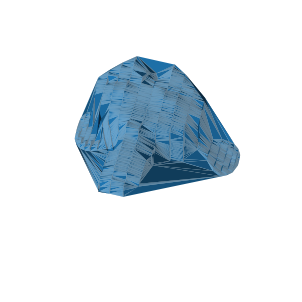

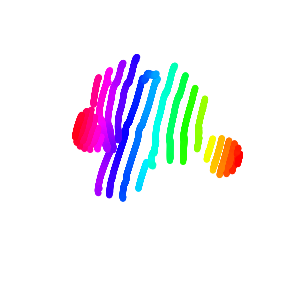

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

def draw3DLine(start,end):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start,y_start,z_start = start
    x_end,y_end,z_end = end

    print("start = ({},{},{})".format(x_start,y_start,z_start))
    print("end = ({},{},{})\n".format(x_end,y_end,z_end))

    ax.scatter(x_start,y_start,z_start,c='r',marker='o')
    ax.plot([x_start ,x_end],[y_start,y_end],[z_start,z_end])

def drawSurfaceObject(points):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(points[0,:],points[1,:],points[2,:])     

    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()
    
def drawPointObject(points):
    figure = plt.figure()
    ax = Axes3D(figure)
    my_cmap = plt.get_cmap('hsv')
    ax.scatter3D(points[0,:],points[1,:],points[2,:],s=100,alpha = 0.8, c =(points[0,:]), cmap = my_cmap, marker='.', )     
        
    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()

print(point)
drawSurfaceObject(point)
drawPointObject(point)
